<a href="https://colab.research.google.com/github/DanielBugelnig/U-Net/blob/arthur/u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
white = '#000000'
print(white.convert("L"))


AttributeError: 'str' object has no attribute 'convert'

In [ ]:
!pip install torch

In [1]:
!pip install torchinfo

In [2]:
# Creating U-Net architecture

# page 4 of the paper: (https://arxiv.org/pdf/1505.04597.pdf)

# Network Architecture
# The network architecture is illustrated in Figure 1. It consists of a contracting
# path (left side) and an expansive path (right side). The contracting path follows
# the typical architecture of a convolutional network. It consists of the repeated
# application of two 3x3 convolutions (unpadded convolutions), each followed by
# a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
# for downsampling. At each downsampling step we double the number of feature
# channels. Every step in the expansive path consists of an upsampling of the
# feature map followed by a 2x2 convolution (“up-convolution”) that halves the
# number of feature channels, a concatenation with the correspondingly cropped
# feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in
# every convolution. At the final layer a 1x1 convolution is used to map each 64-
# component feature vector to the desired number of classes. In total the network
# has 23 convolutional layers.
# To allow a seamless tiling of the output segmentation map (see Figure 2), it
# is important to select the input tile size such that all 2x2 max-pooling operations
# are applied to a layer with an even x- and y-size.

# The reduced output size within a single tile (e.g., 388x388 for a 572x572 input) ensures that the predictions are based on full context,
# avoiding incomplete or invalid segmentations near the borders.




#pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F #for ReLu
import torchvision.transforms.functional as Trans
from torchinfo import summary

class UNet(nn.Module):
    def __init__(self, input_number, output_number):
        super(UNet, self).__init__()
        self.input_number = input_number
        self.output_number = output_number


        # Encoder
        # input: 4d tensor: batch_size x input_number x 572x572 --> input number=1 for grayscale image, 3 for RGB image
        # assuming 572x572 image
        self.conv1 = nn.Conv2d(self.input_number, 64, kernel_size=3, padding=0) # 64x570x570
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=0) # 64x568x568
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x284x284

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=0) # 128x282x282
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=0) # 128x280x280
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 128x140x140

        self.conv5 = nn.Conv2d(128,256, kernel_size=3, padding=0) # 256x138x138
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=0) # 256x136x136
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 256x68x68

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=0) # 512x66x66
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=0) # 512x64x64
        self.maxPool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 512x32x32

        self.conv9 = nn.Conv2d(512, 1024, kernel_size=3, padding=0) # 1024x30x30
        self.conv10 = nn.Conv2d(1024, 1024, kernel_size=3, padding=0) # 1024x28x28

        # Decoder
        # Upsampling by a factor of 2, --> stride=2, kernel_size=2
        # 2x2 up convolution halves the feature channels

        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 512x56x56 --> output size formular(input) # stride * (input-1) + kernel_size -2 *padding + output_padding = 2*(28-1) + 2 - 2*0 + 0 = 56
        self.conv1b = nn.Conv2d(1024, 512, kernel_size=3, padding=0) # 512x54x54 other 512 features come from encoder site
        self.conv2b = nn.Conv2d(512, 512, kernel_size=3, padding=0) # 512x52x52

        self.upconv2 = nn.ConvTranspose2d(512, 256, 2, 2) # 512x104x104
        self.conv3b = nn.Conv2d(512, 256, 3, padding=0) #256x102x102
        self.conv4b = nn.Conv2d(256, 256, 3, padding=0) # 256x100x100

        self.upconv3 = nn.ConvTranspose2d(256, 128, 2,2,) #256x200x200
        self.conv5b = nn.Conv2d(256, 128, 3, padding=0) #128x198x198
        self.conv6b = nn.Conv2d(128, 128, 3, padding=0) #128x196x196

        self.upconv4 = nn.ConvTranspose2d(128, 64, 2, 2) #128x392x392
        self.conv7b = nn.Conv2d(128, 64, 3, padding=0) #64x390x390
        self.conv8b = nn.Conv2d(64,64,3, padding=0) # 64x388x388
        self.final_conv = nn.Conv2d(64, self.output_number, kernel_size=1, padding=0) #2x388x388

    def cropConcat(self, encoder, decoder):
        # crops the encoder tensor and concatenate its with the decoder tensor
        _,_,H,W = decoder.shape
        cropped_enc = Trans.center_crop(encoder, [H,W]) # crops the encoder tensor in the centre
        return torch.cat((cropped_enc, decoder), dim=1) # concatenates at the feature dimension

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x))
        x = self.maxPool1(x1)

        x = F.relu(self.conv3(x))
        x2 = F.relu(self.conv4(x))
        x = self.maxPool2(x2)

        x = F.relu(self.conv5(x))
        x3 = F.relu(self.conv6(x))
        x = self.maxPool3(x3)

        x = F.relu(self.conv7(x))
        x4 = F.relu(self.conv8(x))
        x = self.maxPool4(x4)

        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))

        # Decoder
        x = self.upconv1(x)  # size 512x56x56

        x = self.cropConcat(x4, x) # concatination1 size 1024x56x56
        x = F.relu(self.conv1b(x))
        x = F.relu(self.conv2b(x))
        x = self.upconv2(x)

        x = self.cropConcat(x3,x)
        x = F.relu(self.conv3b(x))
        x = F.relu(self.conv4b(x))
        x = self.upconv3(x)

        x = self.cropConcat(x2,x)
        x = F.relu(self.conv5b(x))
        x = F.relu(self.conv6b(x))
        x = self.upconv4(x)

        x = self.cropConcat(x1,x)
        x = F.relu(self.conv7b(x))
        x = F.relu(self.conv8b(x))
        x = self.final_conv(x)
        x = F.softmax(x,1)
        return x


model = UNet(1,1)
summary(model, input_size=(1, 1, 572, 572))  # Example input size


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 388, 388]          --
├─Conv2d: 1-1                            [1, 64, 570, 570]         640
├─Conv2d: 1-2                            [1, 64, 568, 568]         36,928
├─MaxPool2d: 1-3                         [1, 64, 284, 284]         --
├─Conv2d: 1-4                            [1, 128, 282, 282]        73,856
├─Conv2d: 1-5                            [1, 128, 280, 280]        147,584
├─MaxPool2d: 1-6                         [1, 128, 140, 140]        --
├─Conv2d: 1-7                            [1, 256, 138, 138]        295,168
├─Conv2d: 1-8                            [1, 256, 136, 136]        590,080
├─MaxPool2d: 1-9                         [1, 256, 68, 68]          --
├─Conv2d: 1-10                           [1, 512, 66, 66]          1,180,160
├─Conv2d: 1-11                           [1, 512, 64, 64]          2,359,808
├─MaxPool2d: 1-12                        [1, 51

Number of pages: 30

Tensor size image_tensor: torch.Size([1, 512, 512])
tensor([[[0.3922, 0.2471, 0.2431,  ..., 0.5333, 0.4471, 0.4902],
         [0.4431, 0.2863, 0.2157,  ..., 0.5451, 0.5176, 0.5137],
         [0.3098, 0.1529, 0.2039,  ..., 0.5176, 0.5176, 0.5451],
         ...,
         [0.3765, 0.5176, 0.5137,  ..., 0.1765, 0.0980, 0.0000],
         [0.2627, 0.4157, 0.5216,  ..., 0.4078, 0.3255, 0.0824],
         [0.3333, 0.4784, 0.4745,  ..., 0.4588, 0.3137, 0.3216]]])
Tensor size label tensor: torch.Size([1, 512, 512])
Tensor size prediction mask: torch.Size([1, 512, 512])
Tensor size label mask: torch.Size([1, 512, 512])


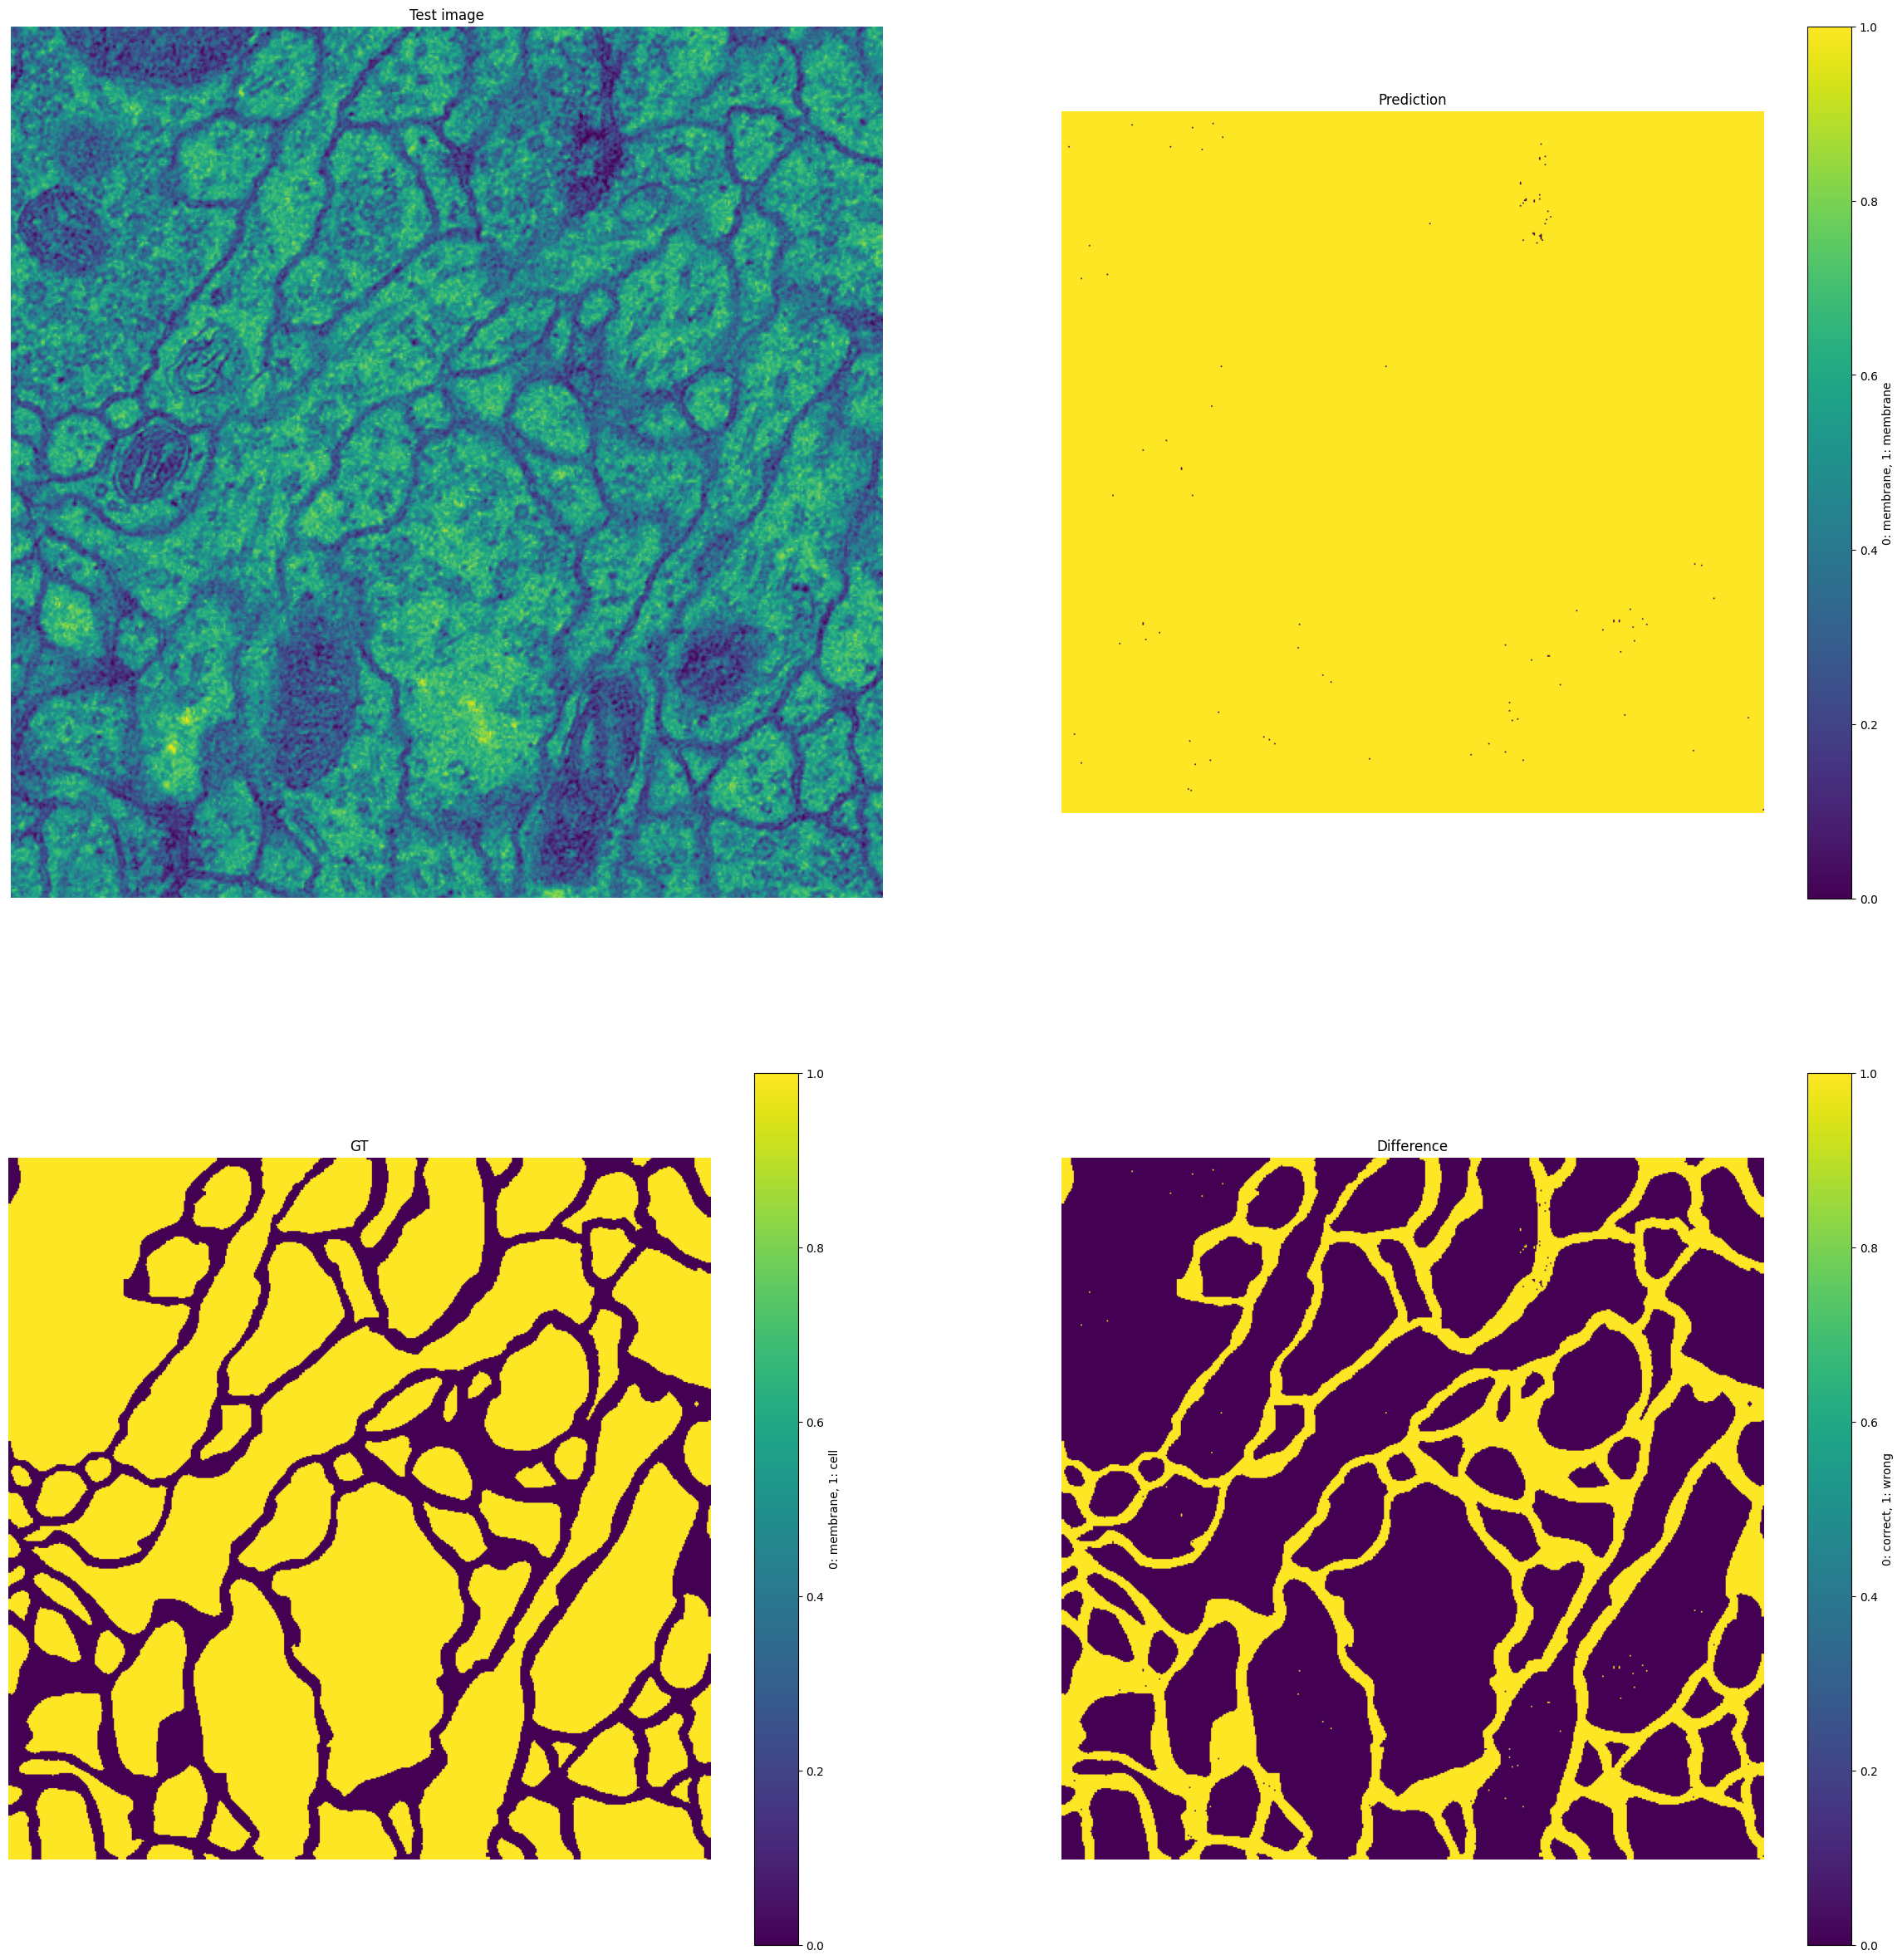

In [ ]:
# Script for visualizing and testing the U-net model
# Explanation of code in visualization_ReadMe.md

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
import torchvision.models as models
import torchvision.transforms.functional as Trans

# Count images in TIF file
def countImages(image):
    # Count images
    image_count = 0
    try:
        while True:
            image.seek(image_count)
            image_count +=1
    except EOFError:
        pass

    print(f"Number of pages: {image_count}\n")
    return image_count

# Display all Images of the dataset
def displayImages(image, title):
    plt.figure(figsize=(20,20))
    for i in range(countImages(image)):
        try:
            image.seek(i)
            plt.subplot(6,5, i+1)
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"Page {i+1}")
        except EOFError:
            break

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show(block=False)

# Prediction function for a single image
def predict_single(image, model):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        pred = model(image)
    return pred


# function only for testing purposes of visualization
def evaluate_test(prediction, expected):
    probabilities = torch.sigmoid(prediction)
    probabilities = prediction
    predicted_segmentation = (probabilities > 0.5).int()  #convert to binary mask (1,1,H,W)

    _,H,W = predicted_segmentation.shape
    H=388
    W=388
    expected_segmentation = Trans.center_crop(expected, [H,W]) # crop the expected label to size of model output (from 512 to 388)
    predicted_segmentation = Trans.center_crop(predicted_segmentation, [H,W]) # crop the expected label to size of model output (from 512 to 388)

    diff = (expected_segmentation != predicted_segmentation).int()
    return predicted_segmentation, expected_segmentation, diff  #return both binary masks

# correct evaluation function
def evaluate(prediction, expected):
    probabilities = torch.sigmoid(prediction)
    predicted_segmentation = (probabilities > 0.5).int()  #convert to binary mask (1,1,H,W)

    _,H,W = predicted_segmentation.shape
    expected_segmentation = Trans.center_crop(expected, [H,W]) # crop the expected label to size of model output (from 512 to 388)

    diff = (expected_segmentation != predicted_segmentation).int() # difference mask
    return predicted_segmentation, expected_segmentation, diff  #return both binary masks

# selecting device and loading model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.load('u_net.pth', weights_only=False)
#model = model.to(device)



# ----------------------------------------------------------------------
# Displaying the complete  train/test dataset
#Training images
train_image = Image.open("ISBI-2012-challenge/train-mirror.tif")
#displayImages(train_image, "Training images")
# Training labels
train_label = Image.open("ISBI-2012-challenge/train-labels.tif")
#displayImages(train_label, "Training labels")

# #Test images
test_image = Image.open("ISBI-2012-challenge/test-mirror.tif")
# displayImages(test_image, "Test images")
# Training labels
test_label = Image.open("ISBI-2012-challenge/test-labels.tif")
# displayImages(test_label, "Test labels")
#input("press enter for close")

#---------------------------------------------------------------------



# --------------------------------------------------------------------
# Visualization
# What we want to display: Image, Prediction; Groundtruth, Difference
# Image size = 512x512,
# Prediction size = 388x388
# select a random image of test set
randomID = random.randint(1, countImages(test_image))
test_image.seek(randomID)
test_label.seek(randomID)

plt.figure(figsize=(30,30))

# Test image
plt.subplot(2,2, 1)
plt.imshow(test_image)
plt.title(f"Test image")
plt.axis("off")


# Transform the test image/label to tensor
transform = transforms.Compose([transforms.ToTensor()]) # convert PIL image to (C,H,W)
image_tensor = transform(test_image)
label_tensor = transform(test_label)
#image_tensor = image_tensor.unsqueeze(0) #  Shape (1,C,H,W)
#torch.set_printoptions(threshold=torch.inf)
print(f"Tensor size image_tensor: {image_tensor.shape}") # (1,1,512,512)
print(image_tensor)
print(f"Tensor size label tensor: {label_tensor.shape}") # (1,1,512,512)
#print(label_tensor)

# Run the U-net for one image
#prediction = predict_single(test_image, model)

# --> prediction_mask, label_mask, diff = evaluate(prediction, label_tensor)
prediction_mask, label_mask, diff = evaluate(image_tensor, label_tensor)
print(f"Tensor size prediction mask: {prediction_mask.shape}")
print(f"Tensor size label mask: {label_mask.shape}")
prediction_mask.squeeze_(0)
label_mask.squeeze_(0)
diff.squeeze_(0)
plt.subplot(2,2,2)
plt.imshow(prediction_mask, cmap='viridis')
plt.title(f"Prediction")
cbar = plt.colorbar()
cbar.set_label("0: membrane, 1: membrane")
plt.axis("off")
plt.subplot(2,2,3)
plt.imshow(label_mask, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label("0: membrane, 1: cell")
plt.title(f"GT")
plt.axis("off")
plt.subplot(2,2,4)
plt.imshow(diff, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label("0: correct, 1: wrong")
plt.title(f"Difference")
plt.axis("off")
# add colorbar

plt.show()

In [6]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as Trans
from PIL import Image
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

#Loading data
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class Dataset(Dataset):
  def __init__(self, image_path, label_path, transform=None):
    self.images = Image.open(image_path)
    self.labels = Image.open(label_path)
    self.transform = transform

  def __len__(self):
    return self.images.n_frames

  def __getitem__(self, idx):
    #find specific frame
    self.images.seek(idx)
    self.labels.seek(idx)
    #grayscale conversion (if necessary)
    image = self.images.convert("L")
    label = self.labels.convert("L")
    if self.transform:
      image = self.transform(image)
      label = self.transform(label)
    return image, label

transform = transforms.Compose([transforms.ToTensor()])

#original
#train_dataset = Dataset("ISBI-2012-challenge/train-volume.tif", "ISBI-2012-challenge/train-labels.tif", transform)
#test_dataset = Dataset("ISBI-2012-challenge/test-volume.tif", "ISBI-2012-challenge/test-labels.tif", transform)

#mirrored
train_dataset = Dataset("ISBI-2012-challenge/train-mirror.tif", "ISBI-2012-challenge/train-labels.tif", transform)
test_dataset = Dataset("ISBI-2012-challenge/test-mirror.tif", "ISBI-2012-challenge/test-labels.tif", transform)


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#print(train_dataset.images.n_frames)

#print(train_dataset.shape)

#Training
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1,1).to(device)
#optimizer= optim.Adam(model.parameters(),0.00001)
optimizer = optim.SGC(model.parameters(),0.00001,momentum=0.99)
criterion = nn.CrossEntropyLoss() #binary cross entropy loss with sigmoid



def train(model, dataloader, criterion, optimizer, nrOfEpochs):
  model.train()
  for i in range(nrOfEpochs):
    running_loss = 0.0
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device);
      #print(images.shape)
      optimizer.zero_grad()
      outputs=model(images)
      #outputs = (outputs > 0.5).float()
      labels = Trans.center_crop(labels, [388,388])
      #assert outputs.shape == labels.shape, f"Shape mismatch: {outputs.shape} vs {labels.shape}"
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    '''
    #for visualization of the training data
    for j in range(dataloader.batch_size):
        plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(images[j].cpu().numpy().squeeze(), cmap='viridis')
        plt.subplot(2,2,2)
        plt.imshow(labels[j].cpu().numpy().squeeze(), cmap='viridis')
    '''
    train_loss = running_loss/len(dataloader)
    print(f"Epoch {i+1}/{nrOfEpochs}\nLoss:{train_loss}")


#Evaluation
def test(model, dataloader, criterion):
  model.eval()
  running_loss = 0.0
  avgAcc=0.0
  avgPrec=0.0
  avgRec=0.0
  avgF1=0.0
  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device);
      outputs = model(images)
      labels = Trans.center_crop(labels, [388,388])
      loss = criterion(outputs,labels)
      running_loss+=loss.item()
      outputs = (outputs > 0.5).int()
      #visualisation and evaluation
      for j in range(dataloader.batch_size):
        '''
        plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(images[j].cpu().numpy().squeeze(), cmap='viridis')
        plt.subplot(2,2,2)
        plt.imshow(labels[j].cpu().numpy().squeeze(), cmap='viridis')
        plt.subplot(2,2,3)
        #outputs[j]=(outputs[j]>0.5).int()
        plt.imshow(outputs[j].cpu().detach().numpy().squeeze(), cmap='viridis')
        plt.subplot(2,2,4)
        diff=(outputs[j]!=labels[j]).int()
        plt.imshow(diff.cpu().detach().numpy().squeeze(),cmap='viridis')
        plt.show()
        '''
        #Output image to binary values
        #outputs[j] = (outputs > 0.5).float()
        labels = labels.int()
        TP = ((labels[j])*(outputs[j])).sum()
        TN = ((1-labels[j])*(1-outputs[j])).sum()
        FP = ((1-labels[j])*(outputs[j])).sum()
        FN = ((labels[j])*(1-outputs[j])).sum()

        accuracy = (TP+TN)/(TP+TN+FP+FN)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        f1 = 2*(precision*recall)/(precision+recall)
        '''
        print(f"Accuracy:{accuracy}")
        print(f"Precision:{precision}")
        print(f"Recall:{recall}")
        print(f"F1 Score:{f1}\n")
        '''
        avgAcc+=accuracy
        avgPrec+=precision
        avgRec+=recall
        avgF1+=f1

  print(f"Avg Accuracy:{avgAcc/len(dataloader)}")
  print(f"Avg Precision:{avgPrec/len(dataloader)}")
  print(f"Avg Recall:{avgRec/len(dataloader)}")
  print(f"Avg F1 Score:{avgF1/len(dataloader)}\n")

  test_loss = running_loss/len(dataloader)
  print(f"Test loss:{test_loss}")
  return avgAcc/len(dataloader), avgPrec/len(dataloader), avgRec/len(dataloader), avgF1/len(dataloader)

x = [0]*10
acc = [0]*10
prec = [0]*10
rec = [0]*10
f1 = [0]*10

#torch.load('unet_50ep_lr0001_mirr.pth', map_location=torch.device('cpu'))

#Running code:
for i in range(10):
  train(model, train_loader, criterion, optimizer, 10)
  x[i] = 10*i
  acc[i], prec[i], rec[i], f1[i] = test(model, test_loader, criterion)

#Plot acc, prec, rec, f1
plt.figure()
plt.plot(x, acc, label='Accuracy')
plt.plot(x, prec, label='Precision')
plt.plot(x, rec, label='Recall')
plt.plot(x, f1, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Metrics over Epochs')
plt.legend()
plt.show()


#Save model - change name to: unet _ nr of epochs _ learning rate 0.xxx as lrxxx _ which dataset
#torch.save(model.state_dict(), 'unet_100ep_lr00001_mirr.pth')


Epoch 1/10
Loss:0.7011557320753733
Epoch 2/10
Loss:0.6904335061709086
Epoch 3/10
Loss:0.6750059266885121
Epoch 4/10
Loss:0.6149304529031118
Epoch 5/10
Loss:0.5306750645240148
Epoch 6/10
Loss:0.5227540185054144
Epoch 7/10
Loss:0.5200536847114563
Epoch 8/10
Loss:0.5155275017023087
Epoch 9/10
Loss:0.5106529047091802
Epoch 10/10
Loss:0.5043763915697733
Avg Accuracy:0.7220309376716614
Avg Precision:0.7219095230102539
Avg Recall:0.9999812245368958
Avg F1 Score:0.837672770023346

Test loss:0.5598373393217723
Epoch 1/10
Loss:0.4962790280580521
Epoch 2/10
Loss:0.48743318219979603


KeyboardInterrupt: 